# Convolutional Neural Networks: A Story

By Laxman Singh Tomar

This project introduces convolutional neural networks, also known as *convnets*, a type of deep learning model almost universally used in computer vision applications.
Our window to the world of convnets will be a model trained to classify whether the given image contains a dog or a cat. The model is trained on images from Kaggle's [Dogs vs. Cats Identification](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). We'll look at two architectures: one is a simple convnet trained from scratch. And the other will be a VGG16 pre-trained convnet and fine tune it to the classification of images.

Once the model is trained, we can use it to generate predictions for images in the dataset. 

To understand the inner workings of the model better, we will extract activations of an input image at each stage of the network to see how the input image is processed and what features are extracted.

# Outline

1. Introduction of Project
   - 1.1 Project Objective
   
   
2. Convnets - A Friendly Introduction


3. Project Setup
    - 3.1 Importing Libraries
    - 3.2 Importing the Data
    
    
4. Deep Learning for Small Datasets
    - 4.1 Data Preprocessing
    
    
5. Building Model : Convnet from Scratch
    - 5.1 Predictions #1
    
        
6. Visualizing what Convnets Learn
    - 6.1 Visualizing Intermediate Activations
    
    
7. Building Model : Pre-trained convnet using VGG16
    - 7.1 Predictions #2
    
    
8. Visualizing what Convnets Learn
    - 8.1 Visualizing Convnets Filters
    
    
9. Analysis and Conclusions

# 1. Introduction of Project

# 1.1 Project Objective

To classify the given images as dogs and cats and to draw insights by visualizing the behind the scenes of CNNs.

# 2. Convnets - A Friendly Introduction

**Pre-requisites** : Understanding of Artificial Neural Networks and related concepts.

Convolutional Neural Network or popularly known as convnets are a type of neural network. It's a stack of Conv2D and MaxPooling2D layers.

- **Input to a Convnet** : A 3D tensor of shape (img_height, img_width, img_channels)


- **Output of every Conv2D & MaxPooling2D layer** : A 3D tensor of shape (height, width, channels)
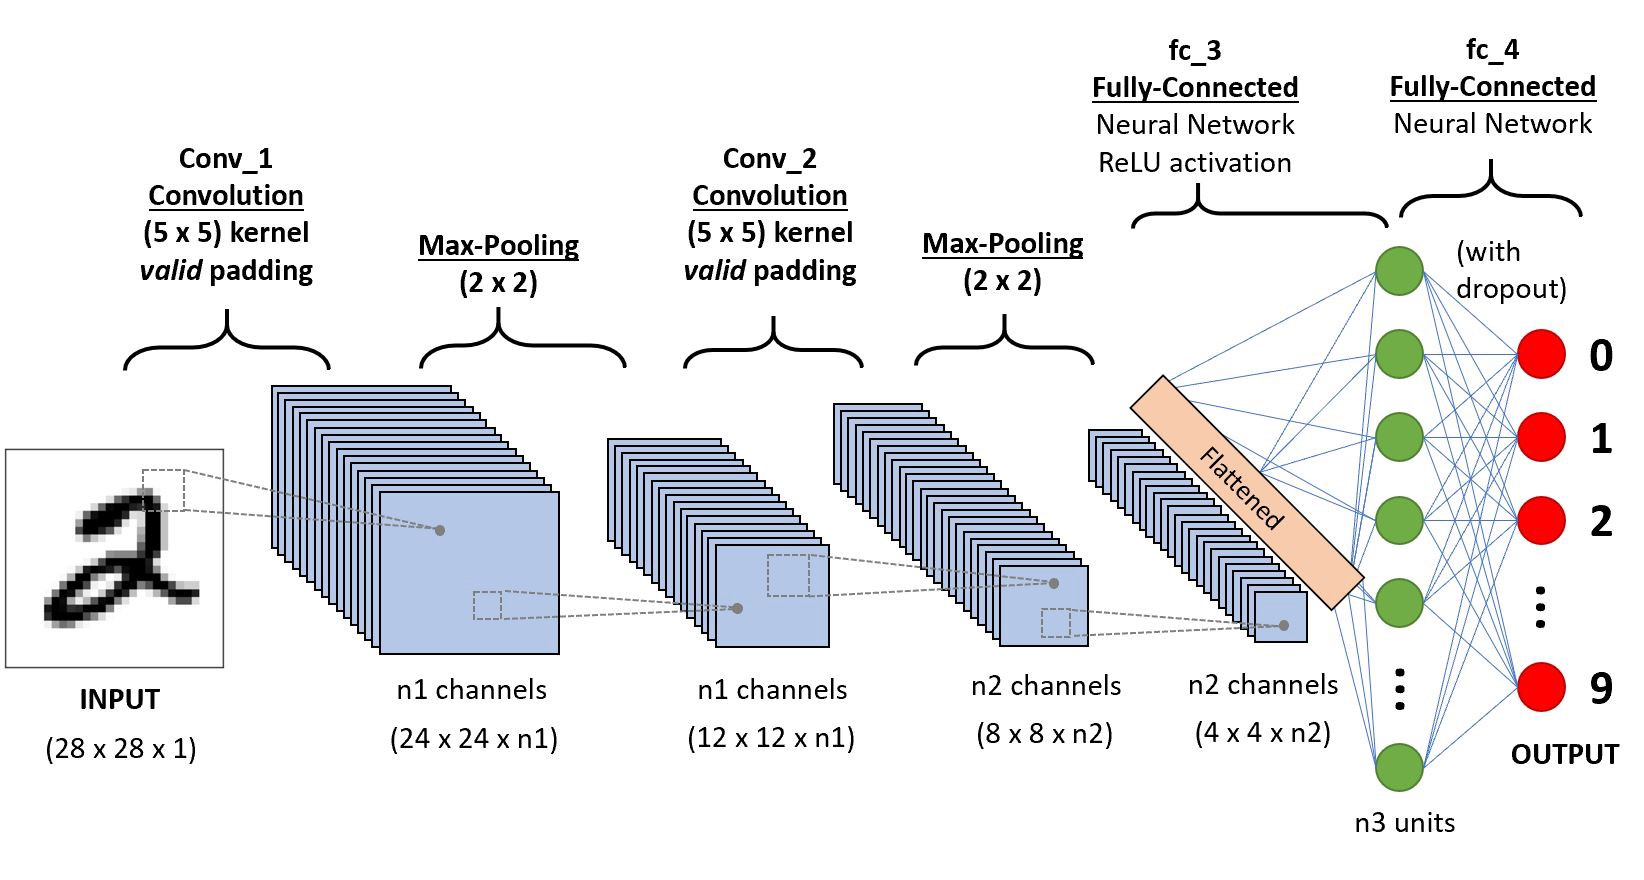

As you go deeper into the network the width and height of image tends to shrink. Number of channels can be controlled by the first argument passed to the conv2D layer.

The last output tensor is feeded to a stack of Dense layers. These classifiers process vectors which are 1D tensor whereas the current output is a 3D tensor. So, to convert our 3D tensor into 1D tensor, we use Flatten layer; and then add a few dense layers on top.

There are 2 important operations involved in CNNs : Convolution and Max-Pooling; let's study them briefly.


### Convolution Operation

The difference between a densely connected layer and a convolution layer is that dense layer learns global patterns whereas convolution layer learns local patterns in their input feature space.

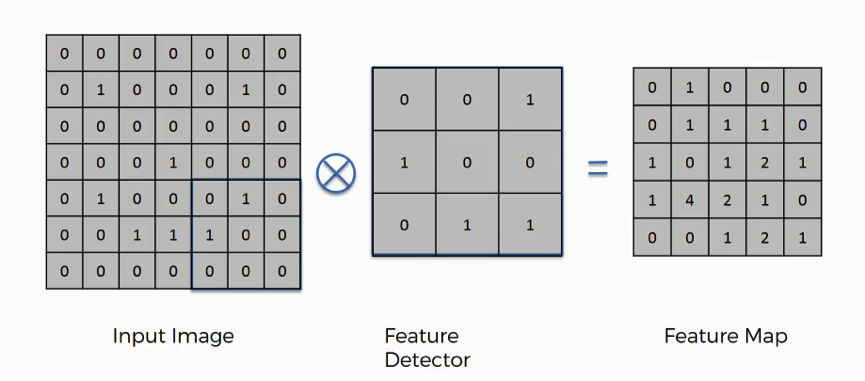

Convnets have 2 interesting properties :

1. If a convnet learns a pattern then it can recognize that pattern anywhere irrespective of it's new location.

2. Convnets learn spatial hierarchies of patterns i.e. first layer will learn local patterns as edges, second will learn larger patterns made by first layers and so on.

Convolutions operate over 3D tensors called feature maps; with two axes img_height and img_width; as well a depth or channel axis. For B&W it'll be '1' and for RGB it'll be '3'.

Different channels in depth axis stand for what is known as a filter. What each layer in the network does is, it creates a feature map when a filter is run over each possible location in the input image.

**Padding** : If you want to get an output feature map with same spatial dimensions as input, you can use padding. By setting the padding argument to *same* we can pad in a way as output has same height and width as the input.

**Strides** : Distance between 2 successive windows is a parameter of the convolution, called it's stride. It's used to downsample feature maps. But max-pooling operation is a popular alternative.

### Max-Pooling Operation

It's used to extract windows from input feature maps and output max value of each channel. It's different from convolution in the sense that it downsamples the feature maps with 2 x 2 windows and a stride of 2; compared to that of 3 x 3 windows and no stride.

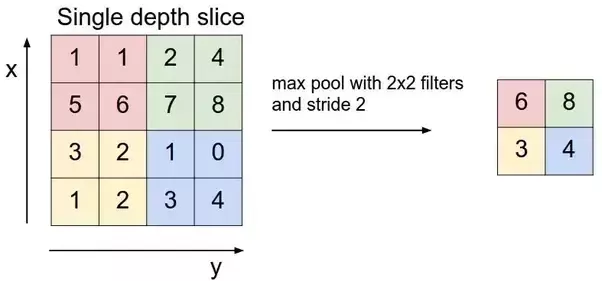

The reason to do downsampling is to reduce the number of feature-map coefficients to process. 

# 3. Project Setup

## 3.1 Importing the Libraries

This project uses keras- an open source library written by F. Chollet, matplotlib, sklearn, numpy and pandas and the dependencies of these libraries.

In [16]:
# Notebook Setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
#Importing Necessary Libraries

import os, re, cv2, random
import numpy as np
import pandas as pd
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## 3.2 Importing the Data

In this dataset, we've 2 directories, where we've stored our images of cats dogs namely. It'll be better to move uncompressed files to another directory for modeling.

In [18]:
# Setting up Paths and Directories

train_dir = '../input/train/'
test_dir = '../input/test/'

train_images = [train_dir + i for i in os.listdir(train_dir)]

test_images = [test_dir + i for i in os.listdir(test_dir)]

If you'd navigate to the directory, you'll see all the images are numbered. It will be better to construct a function to sort the image files based on the numeric value in each file name. Let's sort all the images:

In [19]:
# To sort the Images as all Images have respective file names

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text)]

# Deep Learning for Small Datasets

You'll often hear that deep learning only works if you've ample amount of data available to you. Well I believe it's somewhat true as one of the fundamental traits of deep learning is that it doesn't need feature engineering; it learns representations of data on it's own. For that to be achieved, lots of training data needs to be available. It's true for high dimensional input samples like images.

Well, also by "small" I mean few hundreds of samples not few tens of samples for a complex problem. If the task isn't much complex then a small and well-regularized model will work fine enough. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite lack of data, without the need of any custom feature engineering.

But learning representations on small data is difficult for complex problems like computer vision, many pre-trained models are publicly available for download and can be used to bootstrap powerful models out of very little data. 

The dataset I'm using isn't packaged with keras. So, I've downloaded it from Kaggle. This competition was won by the entrants who used CNNs. As this dataset is quite large and it contains around 25000 images, due to hardware constraints I won't be able to use the entire dataset. I'll be using only 1300 images each of cats and dogs instead, hoping that would be enough with appropriate techniques for learning.

## 4.1 Data Preprocessing

In [20]:
# Sorting the Training set and Testing Set; using 1300 images each of cats and dogs instead of all 25000 to speed up in the learning process

train_images.sort(key = natural_keys)

train_images = train_images[0:1300] + train_images[12500:13800]

test_images.sort(key = natural_keys)

Now that we've split images in train and test, it's time to resize and label our images. Images will be of different sizes, it'll be better to resize all images to size 150 x 150. I'll create 2 arrays: one for resized images and one for their respective labels. '1' will be for dogs and '0' for cats.

In [ ]:
# To represent images in numbers and generating labels for supervised learning using OpenCV

img_width = 150
img_height = 150
def data_prep(list_of_images):
    
    """returns 2 arrays:
         x is an array of resized labels
         y is an array of labels"""
    x = []
    y = []
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width, img_height), interpolation = cv2.INTER_CUBIC))
        
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
            
        elif 'cat' in i:
            y.append(0)
        
        else:
            print("Neither Cat or Dog name present in the images")
            
    return x,y

Here we are using OpenCV's resize operations. It resizes the images to given img_height and img_weight using INTER_CUBIC which means a bicubic interpolation over 4 x 4 pixel neighborhood;no padding and no cropping involved.


Let's using the helper function I just defined above, generate resized images and their labels from the training data.

In [21]:
# Generate X and Y using the helper function above

X, y = data_prep(train_images)
print(K.image_data_format())

channels_last


Since K.image_data_format() is the channel_last, input shape to the first keras layer will be (img_width, img_height, 3). Here depth axis '3' specifies that it's an RGB Image. 

It's always better to split our dataset into 2 parts, one is training dataset where we'll train our model and other is validation datatset where we'll our validate our model. Later, I'll report the accuracy and loss on validation set as well while fitting the model using training set.


In [22]:
# Splitting the dataset containing 2600 images into 2 parts, training and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1)

I'll be using batch_size = 16 i.e. 16 is the number of samples in each batch.

In [23]:
no_train_samples = len(X_train)
no_validation_samples = len(X_val)
batch_size = 16

As you already know, data should be formatted accordingly pre-processed floating point tensors before being fed into our network. We know that our data contains jpg files, so the steps for getting it into our network are:

1. Read the images

2. Convert the jpg content to RGB grid of pixels

3. Convert these into floating point tensors

4. Rescale the pixel values (between 0 and 255) to the [0,1] interval (as you know, neural networks prefer to deal with small input values).

It may look like a lot of work to us, but we don't need to worry at all. Keras has a module with image processing capabilities which comes to our rescue. It contains the class ImageDataGenerator which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. 

Overfitting is caused by having too few samples. Given hugh amount of data, chances of your model getting overfit would reduce. Here we have few image samples, the technique which is going to help us is known as Data Augmentation. It works on the principle based on generating new images from the existing images. It aims to achieve that at training time your model won't get to see the same picture twice.

It's done in Keras using a number of random transformations in ImageDataGenerator instance. Some of the transformations are as follows:

- rotation_range : given in degrees which specifies how much to rotate your pictures

- width_shift and height_shift : ranges within which to randomly translate pictures vertically or horizontally.

- shear_range : randomly apply shearing transformations.

- zoom_range : randomly zooming inside pictures.

- horizontal_flip : randomly  flipping  half  the  images  horizontally

- fill_mode : filling  in  newly  created  pixels,  which  can appear after a rotation or a width/height shift.

In [24]:
# Using Image data generator to read images from directories

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

val_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

train_generator = train_datagen.flow(
                    np.array(X_train),
                    y_train,
                    batch_size = batch_size)

validation_generator = val_datagen.flow(
                    np.array(X_val),
                    y_val,
                    batch_size = batch_size)

No new information is being added due to this as we're just producing more images from small amount of existing images. So, I'll also add a dropout layer to fight overfitting. Let's proceed over to the building of the network:

# 5. Building Model: Convnet from Scratch

I'll go a bit fast here. I'm gonna use the same general structure: our convnets will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers. I'll also include one more such stage (Conv2D + MaxPooling2D) so as to augment the capacity of the network as well as to reduce the size of the feature maps, else they'll become too large when we will reach the Flatten layer.

You'll observe a pattern which appears in almost convnets. The depth of the feature maps increases in the network while the size of the feature maps decreases.

As we're tackling a binary classification, I'm ending the network with a single unit( a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

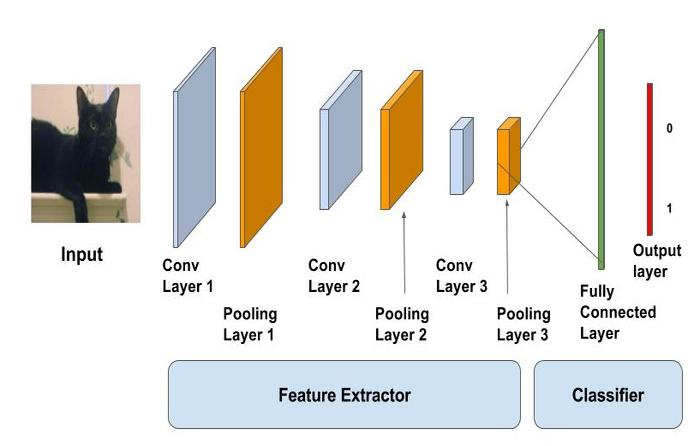

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Let's fit our model to the data using the generator. I'll do that using the fit_generator method, the equivalent of fit for data generators like ours. 

- train_generator : It will yield batches of inputs and targets indefinitely.

- steps_per_epoch: It tells generator how many samples to draw before declaring                    an epoch over.

- epochs : Total number of times our model will go over the training data.

- validation_data : It will yield batches of validation data endlessly.

- validation_steps : It tells generator how many batches to draw from the                            validation generator for evaluation.

In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch = no_train_samples,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps = no_validation_samples)

It's a good practice to always save your models after training:

In [ ]:
model.save('dogs_vs_cats_simple.h5')

Let's plot the loss and accuracy of the model over the training and validation data using training:

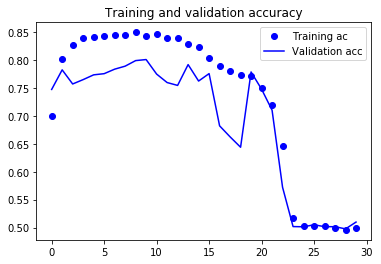

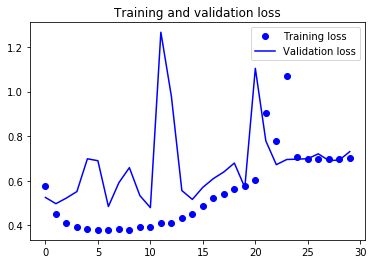

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training ac')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our Model worked fine till 22nd epoch; we will try how a pre-trained convnet behave.

## 5.1 Predictions #1

Now, it's time to predict the classification using the model on the test set. Let's generate X_test and y_test. Here X_test will be image samples for testing and repective labels which as we know will be empty.

In [25]:
X_test, y_test = data_prep(test_images)

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

In [26]:
print(len(X_test))

12500


In [27]:
nb_samples = len(X_test)

Just like we created generators for training and validation, I'll create a generator here for testing, but it's augmentation configuration won't involve other transformations only re-scaling. Then we'll start predicting it.

In [28]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow(np.array(X_test), batch_size = batch_size)

In [29]:
prediction_probs = model.predict_generator(test_generator,steps =np.ceil(nb_samples/batch_size), verbose = 1)

782/782 [==============================] - 4s 5ms/step


Let's convert our prediction probabilities to a CSV file for submission purposes:

In [30]:
counter = range(1, len(test_images) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probs)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("dogsandcats1.csv", index = False)

<a href = 'dogsandcats1.csv'>Download Predictions #1 </a>

# 6. Visualizing What Convnets Learn

People often say that deep learning models are "black boxes". But that statement doesn't apply on convnets for sure. As representations learnt by a convnet can be easily visualized as in large part they're *representations of visual concepts*. There are many techniques for the same as follows:

- **Visualizing Intermediate Convnet Outputs or intermediate activations** : Helps in understanding how successive convnets layers transform their inputs, and for getting an idea of individual convnet filters.

- **Visualizing Convnets Filters** : Helps in understanding what visual pattern each filter in a convnet is receptive to.

- **Visualizing Heatmaps of a class activation in an Image** : Helps in understanding which parts of an image were identified as belonging to a given class

I will try exploring the first two here; and would save the third one for future endeavours.

## 6.1 Visualizing Intermediate Activations

Given a certain input, various convolutional & pooling layers in a network output activations which consists of feature maps. It shows how an input is decomposed into different filters learned by the network. As we know feature maps have 3 dimensions: height, width and depth(channels). Each channel encodes relatively independent features, so the proper way to visualize these feature  maps is by independently plotting the contents of every channel as a 2D image.

Let's input an image- a picture of a cat, not part of the images the network was trained on.

In [31]:
img_path = '../input/test/10020.jpg'

In [32]:
# We preprocess the Image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# It's shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


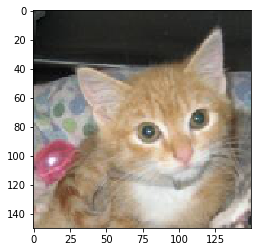

In [33]:
# Displaying the test picture

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

Now, that we've seen the image we're working with, it's time to create our model. It will take batches of images as input, and outputs the activations of all convolution and pooling layers. Now for this, I'll use Model Class from Keras. It's instatiated using two arguments: an input tensor/s and an output tensor/s. The resulting class is a Model just like the Sequential model we're are familiar with. Model Class is different in the sense that here we've multiple outputs unlike Sequential. 

In [34]:
# Instantiating a model from an input tensor and a list of output tensors
from keras import models

# Extracts the outputs of the top 9 layers:
layer_outputs = [layer.output for layer in model.layers[:9]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

This model returns the values of the layer activations in the original model. It has one input and eight outputs: one output per layer activation.

In [35]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For example, this is the activation of the first convolutional layer for the cat image input:

In [36]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a feature map of size 148 x 148 with 32 channels. Let's try plotting the 3rd channel of the activation of the first layer of the original model. 

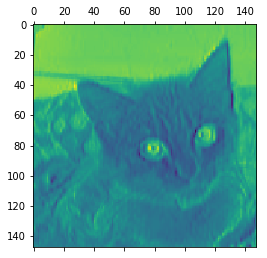

In [37]:
# Visualizing the 3rd channel

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 3], cmap = 'viridis')
plt.show()

This channels appear to encode an edge detector around the ears. Let's try the 16th channel- but note that your channels may vary as specific filters learned by convolutional layers aren't deterministic.

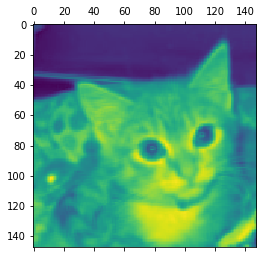

In [38]:
# Visualizing the 16th channel

plt.matshow(first_layer_activation[0, :, :, 16], cmap='viridis')
plt.show()

This one looks like trying to identify shapes of eyes in cat.

Now, finally let's plot a complete visualization of all the activations in the network. I'll extract and plot every channel in each of the eight activation maps, and you'll stack the results in one big image tensor, with channels stacked side by side.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


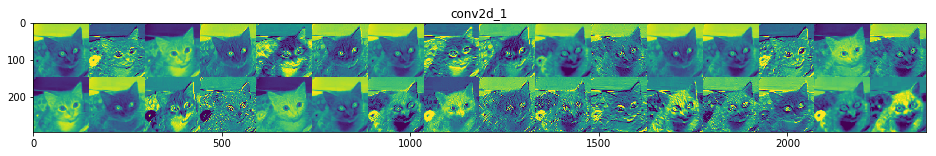

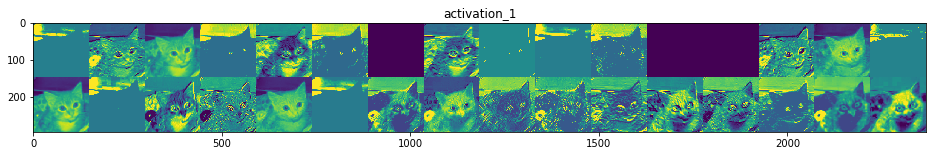

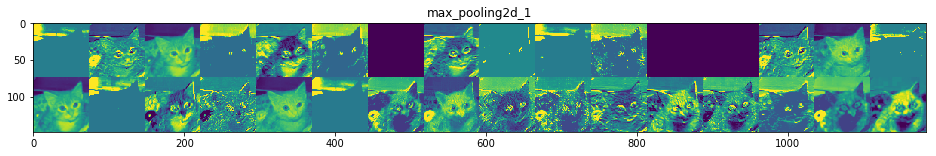

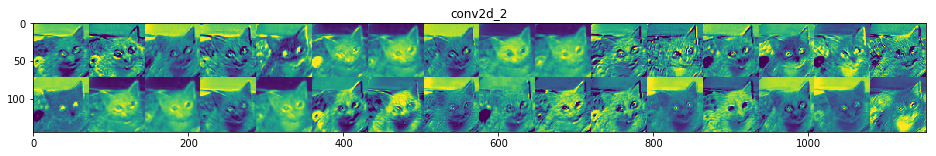

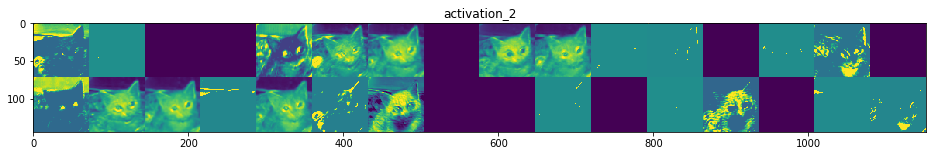

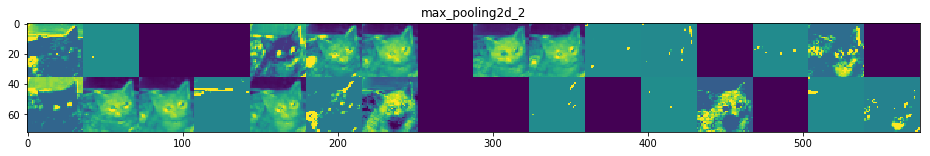

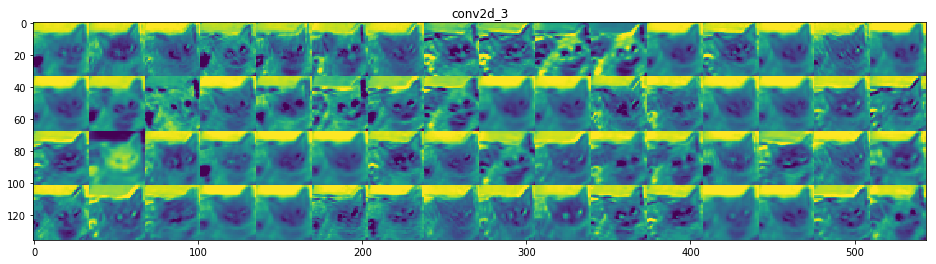

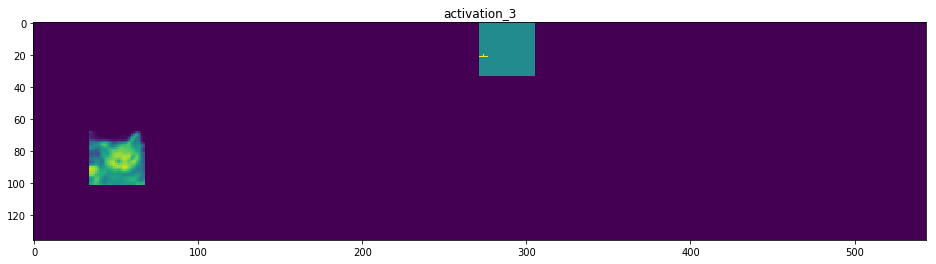

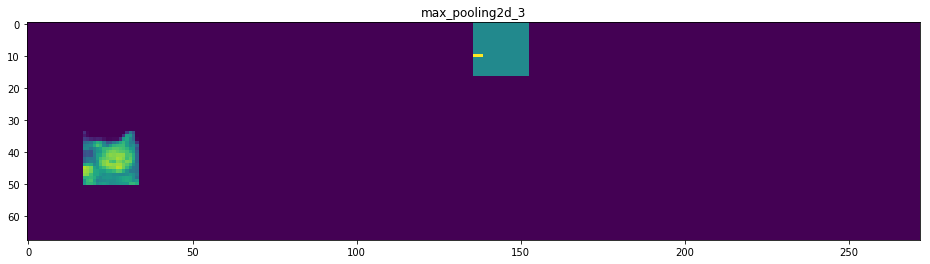

In [39]:
# Visualizing every channel in every intermediate activation

import keras

# These are the names of the layers, so I can have them as part of our plot
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()



Few notable points:

- The first layer aims at detecting shapes of eyes and a bit of edges around ears. At that stage, activation retains almost all of the information present in the initial picture.


- As we go deeper into the network, the activations become increasingly abstract and less visually interpretable. They start encoding things like whiskers etc. So, higher representations contain more information about class of the image rather than it's contents.


- As depth of the layer increases, more and more filters are blank; meaning pattern encoded by the filter isn't found in an input image.

Hence it solidifies our proposition that deep neural networks act as a filtering pipeline with raw data going in, and being repeatedly transformed so that irrelevant information is filtered out and useful information is magnified and refined.

# 7. Building Model: Using Pretrained Convnet VGG16

A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If it's trained on a sufficiently large training dataset, then the representations learnt by it can act as a generic model for the visual world, and in turn it's features can be used for many computer vision problems.

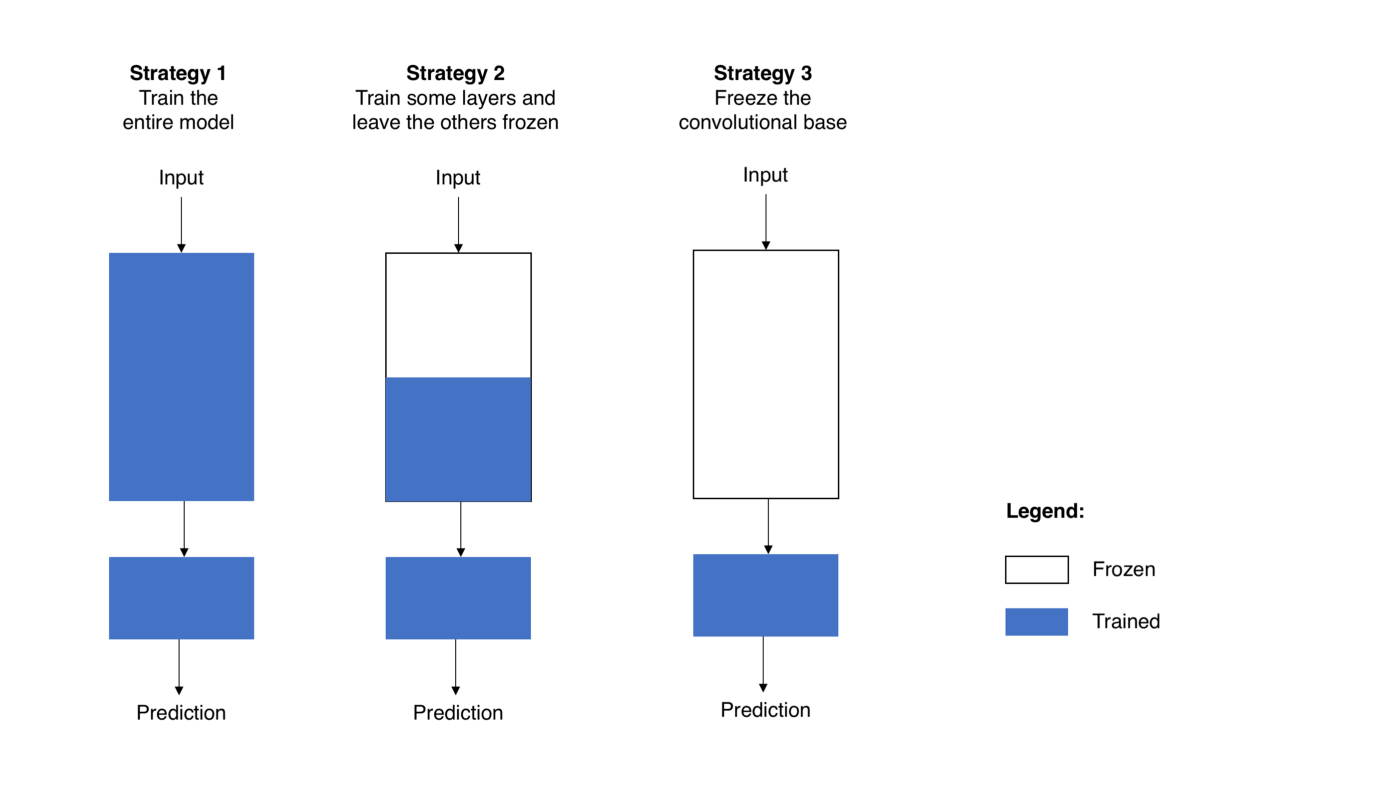

In our case, I'm using a pretrained convnet named **VGG16** which is trained on Imagenet dataset which had around 1.4 million labeled images and 1000 different classes. It contains many animal classes, so it's expected to peform well on our problem.

There are 2 ways to use it: Feature Extraction and Fine Tuning. I'll explain briefly what that means:

- **Feature Extraction**: It aims on extracting interesting features from new samples. These features are then run through a new classifier trained from scratch. As we know CNN contains alternate stack of convolutional and pooling layers. In feature extraction, we take this convolutional base of a pretrained network and run new data through it and then take help of a new classifier on top of it's output.
    Also there are 2 ways to perform it: without Data Augmentation - where you can run your convolutional base over dataset and then can store it on disk somewhere to run this data as input to a classifier - it's cheaper and faster!
    
    The other way is with Data augmentation - when you add the dense layers on top and run the whole thing again and again. But it's expensive than the former one.
    
    
- **Fine Tuning** : It consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the new added part and these top layers. It's been given this name as it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant. Steps to do that:

    1. Add your custom network on top of an already-trained base network

    2. Freeze the base network 

    3. Train the part you added

    4. Unfreeze some layers in the base network

    5. Jointly train both these layers and the part you added

First three steps belong to the feature extraction step and then I'll proceed to fine tune the network:

In [40]:
# Instantiating the VGG16 convolutional base

from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [41]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [42]:
# 1. Custom network over already trained network

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 2. Freezing the conv base network

conv_base.trainable = False

In [45]:
# 3. Training the part we've added

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)


val_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

train_generator = train_datagen.flow(
                    np.array(X_train),
                    y_train,
                    batch_size = batch_size)

validation_generator = val_datagen.flow(
                    np.array(X_val),
                    y_val,
                    batch_size = batch_size)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 13s - loss: 0.5504 - acc: 0.7169 - val_loss: 0.4460 - val_acc: 0.8182
Epoch 2/30
 - 12s - loss: 0.3722 - acc: 0.8575 - val_loss: 0.3678 - val_acc: 0.8457
Epoch 3/30
 - 12s - loss: 0.3139 - acc: 0.8756 - val_loss: 0.3173 - val_acc: 0.8674
Epoch 4/30
 - 12s - loss: 0.2859 - acc: 0.8787 - val_loss: 0.2986 - val_acc: 0.8724
Epoch 5/30
 - 12s - loss: 0.2688 - acc: 0.8888 - val_loss: 0.3021 - val_acc: 0.8775
Epoch 6/30
 - 12s - loss: 0.2373 - acc: 0.9012 - val_loss: 0.3163 - val_acc: 0.8457
Epoch 7/30
 - 12s - loss: 0.2301 - acc: 0.9081 - val_loss: 0.2880 - val_acc: 0.8763
Epoch 8/30
 - 12s - loss: 0.2273 - acc: 0.9000 - val_loss: 0.2815 - val_acc: 0.8750
Epoch 9/30
 - 12s - loss: 0.2218 - acc: 0.9050 - val_loss: 0.2612 - val_acc: 0.8876
Epoch 10/30
 - 12s - loss: 0.2059 - acc: 0.9156 - val_loss: 0.2879 - val_acc: 0.8890
Epoch 11/30
 - 12s - loss: 0.2035 - acc: 0.9113 - val_loss: 0.2632 - val_acc: 0.8826
Epoch 12/30
 - 12s - loss: 0.1936 - acc: 0.9244 - val_loss: 0.2556 - val_a

In [46]:
# 4. Freezing all layers upto a specific one

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [47]:
# 5. Fine Tuning the Model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 142ms/step - loss: 0.1471 - acc: 0.9406 - val_loss: 0.2354 - val_acc: 0.9120
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0986 - acc: 0.9656 - val_loss: 0.2345 - val_acc: 0.9053
Epoch 3/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0899 - acc: 0.9650 - val_loss: 0.2548 - val_acc: 0.9005
Epoch 4/100
100/100 [==============================] - 13s 129ms/step - loss: 0.0777 - acc: 0.9706 - val_loss: 0.2756 - val_acc: 0.9129
Epoch 5/100
100/100 [==============================] - 13s 126ms/step - loss: 0.0642 - acc: 0.9738 - val_loss: 0.2396 - val_acc: 0.9184
Epoch 6/100
100/100 [==============================] - 13s 126ms/step - loss: 0.0476 - acc: 0.9825 - val_loss: 0.2804 - val_acc: 0.9091
Epoch 7/100
100/100 [==============================] - 13s 126ms/step - loss: 0.0548 - acc: 0.9825 - val_loss: 0.3346 - val_acc: 0.8980
Epoch 8/100
100/100 [===========================

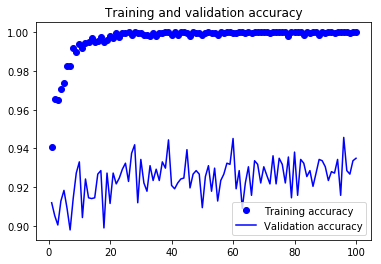

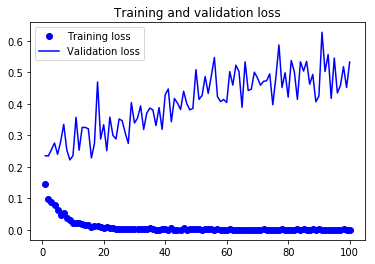

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The validation accuracy looks much cleaner and smoother! 

Well even if you cannot notice that your validation loss curve is improving; it's still improving. The reason is you're displaying an average of point wise loss values but what is important is the distribution of the loss values not their average; as accuracy is the result of binary thresholding of the class probability.

## 7.1 Predictions #2

In [49]:
X_test, y_test = data_prep(test_images)

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in the images
Neither Cat or Dog name present in

In [50]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow(np.array(X_test), batch_size = batch_size)

In [51]:
prediction_probs = model.predict_generator(test_generator,np.ceil(nb_samples/batch_size), verbose = 1)

782/782 [==============================] - 19s 24ms/step


In [52]:
counter = range(1, len(test_images) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probs)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("dogsandcats2.csv", index = False)

<a href = 'dogsandcats2.csv'>Download Predictions #2 </a>

# 8. Visualizing What Convnets Learn

## 8.1 Visualizing Convnet Filters

We've already seen how to visualize intermediate activations. Another way is to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. The process is simple:

1. Build a loss function that maximizes the value of a given filter in a convolutional layer

2. Use SGD to adjust the values of the input image so as to maximize this activation value - here we'll ascend not descend as want the maximum value.

We'll make use of VGG16 model we've just studied about.

In [53]:
# Instantiating VGG16 Model

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

In [54]:
# Function to generate filter visualizations

def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture w.r.t this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [55]:
# Utility function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

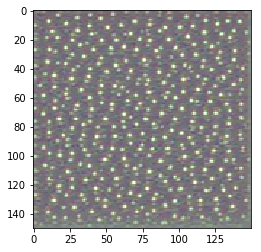

In [56]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in the layer block3_conv1 is reponsive to a polkadot patten. Let's see some more examples:

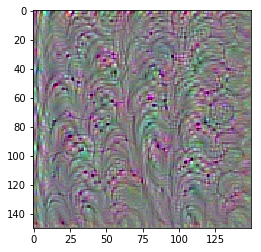

In [57]:
plt.imshow(generate_pattern('block4_conv3', 24))
plt.show()

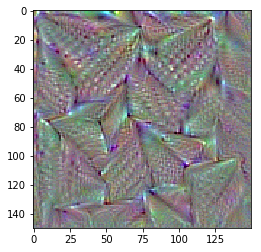

In [58]:
plt.imshow(generate_pattern('block5_conv2', 64))
plt.show()

These filters tell you a lot about how convnets see the world:each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of filters.

# 9. Analysis & Conclusions

- Convnets are the best tools if you've an image classification problem.

- They work by learning a hierarchy of modular patterns and concepts to represent the world we see.

- We can either create a convnet from scratch or a pre-trained convnet,

- A pre-trained convnet when fine-tuned gives better results as it's pre-trained on large datasets hence has learned better representations.

- Convnets upon visualization provide valuable insights about how representations are being learned from inside.

This was a good project and helped me solidify my understanding about Convolutional Neural Nets.